# gluonts12-end_dates

In [1]:
# !pip install mxnet=="1.4.1"

In [2]:
# !pip install gluonts

In [4]:
import gluonts
print(gluonts.__version__)

import mxnet
print(mxnet.__version__)

# standard imports
import numpy as np
import pandas as pd

# Vis
%matplotlib inline
import matplotlib.pyplot as plt
from pprint import pprint

# mxnet
import mxnet as mx

# gluonts
from gluonts.dataset.util import to_pandas

# imports from utility function
import utils_gluonts10 as utils
from utils_gluonts10 import get_dataset, dataset_recipes
from utils_gluonts10_deepar import deepar

0.4.1
1.4.1


INFO:root:Using CPU


In [5]:
print(f"Available datasets: {list(dataset_recipes.keys())}")

Available datasets: ['m4_daily', 'm4_daily_domain', 'm4_daily_id', 'm4_hourly', 'm4_hourly_id', 'm4_monthly', 'm4_monthly_atm', 'm4_monthly_dates', 'm4_monthly_demographic', 'm4_monthly_domain', 'm4_monthly_end032014', 'm4_monthly_end052015', 'm4_monthly_end092007', 'm4_monthly_finance', 'm4_monthly_id', 'm4_monthly_industry', 'm4_monthly_macro', 'm4_monthly_micro', 'm4_monthly_micro_atm', 'm4_monthly_nonmicro_10975_seed42', 'm4_monthly_nonmicro_10975_seed43', 'm4_monthly_nonmicro_10975_seed44', 'm4_monthly_nonmicro_10975_seed45', 'm4_monthly_nonmicro_10975_seed46', 'm4_monthly_nonmicro_10975_seed47', 'm4_monthly_nonmicro_10975_seed48', 'm4_monthly_nonmicro_10975_seed49', 'm4_monthly_nonmicro_10975_seed50', 'm4_monthly_nonmicro_10975_seed51', 'm4_monthly_other', 'm4_quarterly', 'm4_quarterly_atm', 'm4_quarterly_dates', 'm4_quarterly_demographic', 'm4_quarterly_domain', 'm4_quarterly_finance', 'm4_quarterly_id', 'm4_quarterly_industry', 'm4_quarterly_macro', 'm4_quarterly_micro', 'm4_qu

In [6]:
dataname = "m4_monthly_end032014"
dataset = utils.get_dataset(dataname, regenerate=False)

INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_monthly_end032014.


In [7]:
# get the first time series in the training set
train_entry = next(iter(dataset.train))
test_entry = next(iter(dataset.test))

# check keys
print(train_entry.keys())
print(test_entry.keys())

# check length of the series
print("length train dataset", len(dataset.train))
print("length test dataset", len(dataset.train))


dict_keys(['start', 'item_id', 'target', 'feat_static_cat', 'source'])
dict_keys(['start', 'item_id', 'target', 'feat_static_cat', 'source'])
length train dataset 1807
length test dataset 1807


In [8]:
train_entry

{'start': Timestamp('1750-01-31 00:00:00', freq='M'),
 'item_id': 'M3991',
 'target': array([ 1499.,  1677.,  2533.,  1834.,  2922.,  2460.,  2892.,  1969.,
         2781.,  2988.,  3035.,  3172.,  1818.,  2828.,  1979.,  2821.,
         2181.,  2287.,  2320.,  2839.,  1482.,  3094.,  2410.,  2752.,
         1728.,  2112.,  1946.,  2738.,  1812.,  2142.,  2365.,  3492.,
         2875.,  3992.,  1805.,  3433.,  1287.,  2497.,  3733.,  3392.,
         3690.,  4116.,  3163.,  5815.,  4334.,  3794.,  5340.,  7929.,
        15301.,  5824.,  4470.,  7728.,  4461.,  5206.,  5083., 16296.,
         3479.,  3932.,  5383.,  3772.,  3110.,  3995.,  4393.,  5821.,
         5362.,  3344.,  4723.,  4053.,  4007.,  7126.,  3785.,  2627.,
         1963.,  3676.,  5577.,  3394.,  2389.,  1922.,  2924.,  3221.,
         3411.,  4006.,  3108.,  3576.,  2874.,  2759.,  3644.,  3669.,
         4345.,  3471.,  4172.,  3711.,  4095.,  5106.,  6184.,  5464.,
         3786.,  3505.,  4681.,  3651.,  7627.,  55

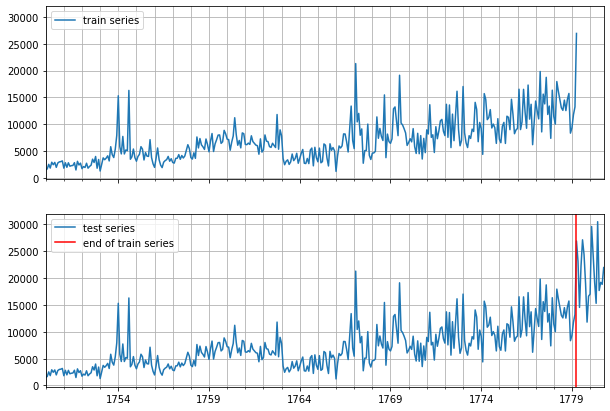

In [9]:
test_series = to_pandas(test_entry)
train_series = to_pandas(train_entry)

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))

train_series.plot(ax=ax[0])
ax[0].grid(which="both")
ax[0].legend(["train series"], loc="upper left")

test_series.plot(ax=ax[1])
ax[1].axvline(train_series.index[-1], color='r') # end of train dataset
ax[1].grid(which="both")
ax[1].legend(["test series", "end of train series"], loc="upper left")

plt.show()

In [10]:
from gluonts.trainer import Trainer
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator

from gluonts.model.deepar import DeepAREstimator

In [11]:
######################
### deepar wrapper ###
def deepar(data="m4_quarterly", seed=42, epochs=100, batches=50):

    dataset = get_dataset(data, regenerate=False)
    mx.random.seed(seed)
    np.random.seed(seed)

    trainer = Trainer(
        ctx=mx.cpu(0),
        epochs=epochs,
        num_batches_per_epoch=batches,
        learning_rate=1e-3,
    )
    
    estimator = DeepAREstimator(
        trainer=trainer,
        cardinality= [
            feat_static_cat.cardinality 
            for feat_static_cat in dataset.metadata.feat_static_cat
        ],
        context_length=dataset.metadata.prediction_length,
        prediction_length=dataset.metadata.prediction_length,
        freq=dataset.metadata.freq,
        use_feat_static_cat=True
    )

    # predictor = estimator.train(training_data=dataset.train,
    #                             validation_data=dataset.test)
    predictor = estimator.train(training_data=dataset.train)

    forecast_it, ts_it = make_evaluation_predictions(
        dataset.test, predictor=predictor, num_samples=100
    )

    agg_metrics, item_metrics = Evaluator()(
        ts_it, forecast_it, num_series=len(dataset.test)
    )

    metrics = ["MASE", "sMAPE", "MSIS", "wQuantileLoss[0.5]", "wQuantileLoss[0.9]"]
    output = {key: round(value, 8) for key, value in agg_metrics.items() if key in metrics}

    output["seed"] = seed
    output["epochs"] = epochs
    output["num_batches"] = batches

    df = pd.DataFrame([output])

    return df

## Results

In [12]:
dataname

'm4_monthly_end032014'

In [13]:
results = pd.DataFrame()

for i in range(42, 52):
    print("Seed:", i)
    df = deepar(data=dataname, seed=i, epochs=100, batches=50)
    pprint(df)
    results = results.append(df)

print(dataname)
results

Seed: 42


INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_monthly_end032014.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 50/50 [00:09<00:00,  5.50it/s, avg_epoch_loss=8.15]
INFO:root:Epoch[0] Elapsed time 9.103 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.151271
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:09<00:00,  5.14it/s, avg_epoch_loss=7.6]
INFO:root:Epoch[1] Elapsed time 12.705 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.599017
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:10<00:00,  4.78it/s, avg_epoch_loss=7.49]
INFO:root:Epoch[2] Elapsed time 10.471 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.487008
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:08<00:00,  6.15it/s, avg_epoch_loss=7.27]
INFO:root:Epoch[3] Elapsed time 8.141 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.26

100%|██████████| 50/50 [00:08<00:00,  6.14it/s, avg_epoch_loss=6.65]
INFO:root:Epoch[36] Elapsed time 8.150 seconds
INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=6.648919
INFO:root:Epoch[37] Learning rate is 0.001
100%|██████████| 50/50 [00:08<00:00,  6.02it/s, avg_epoch_loss=6.72]
INFO:root:Epoch[37] Elapsed time 8.324 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.715969
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 50/50 [00:08<00:00,  5.98it/s, avg_epoch_loss=6.68]
INFO:root:Epoch[38] Elapsed time 8.377 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.680115
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 50/50 [00:12<00:00,  4.03it/s, avg_epoch_loss=6.71]
INFO:root:Epoch[39] Elapsed time 12.422 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.713284
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 50/50 [00:11<00:00,  4.35it/s, avg_epoch_loss=6.68]
INFO:root:Epoch[40] Elapsed time 11.515 seconds
INFO:r

100%|██████████| 50/50 [00:07<00:00,  7.09it/s, avg_epoch_loss=6.65]
INFO:root:Epoch[73] Elapsed time 7.051 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.646571
INFO:root:Epoch[74] Learning rate is 0.0005
100%|██████████| 50/50 [00:06<00:00,  7.66it/s, avg_epoch_loss=6.56]
INFO:root:Epoch[74] Elapsed time 6.546 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.555107
INFO:root:Epoch[75] Learning rate is 0.0005
100%|██████████| 50/50 [00:06<00:00,  7.72it/s, avg_epoch_loss=6.64]
INFO:root:Epoch[75] Elapsed time 6.483 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.638815
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 50/50 [00:06<00:00,  7.69it/s, avg_epoch_loss=6.52]
INFO:root:Epoch[76] Elapsed time 6.509 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.522241
INFO:root:Epoch[77] Learning rate is 0.0005
100%|██████████| 50/50 [00:06<00:00,  7.66it/s, avg_epoch_loss=6.57]
INFO:root:Epoch[77] Elapsed time 6.543 seconds
INFO

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.164738  0.188908  15.945872            0.174113            0.133094   

   seed  epochs  num_batches  
0    42     100           50  
Seed: 43


INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_monthly_end032014.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 50/50 [00:17<00:00,  2.89it/s, avg_epoch_loss=8.13]
INFO:root:Epoch[0] Elapsed time 17.331 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.127494
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:12<00:00,  4.05it/s, avg_epoch_loss=7.54]
INFO:root:Epoch[1] Elapsed time 12.365 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.543767
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:15<00:00,  3.31it/s, avg_epoch_loss=7.34]
INFO:root:Epoch[2] Elapsed time 15.118 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.337388
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:11<00:00,  4.22it/s, avg_epoch_loss=7.19]
INFO:root:Epoch[3] Elapsed time 11.871 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7

100%|██████████| 50/50 [00:11<00:00,  4.22it/s, avg_epoch_loss=6.64]
INFO:root:Epoch[36] Elapsed time 11.846 seconds
INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=6.639475
INFO:root:Epoch[37] Learning rate is 0.001
100%|██████████| 50/50 [00:09<00:00,  5.37it/s, avg_epoch_loss=6.7]
INFO:root:Epoch[37] Elapsed time 9.323 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.699905
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 50/50 [00:09<00:00,  5.44it/s, avg_epoch_loss=6.66]
INFO:root:Epoch[38] Elapsed time 9.196 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.657268
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 50/50 [00:07<00:00,  6.66it/s, avg_epoch_loss=6.69]
INFO:root:Epoch[39] Elapsed time 7.512 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.689208
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 50/50 [00:09<00:00,  5.21it/s, avg_epoch_loss=6.74]
INFO:root:Epoch[40] Elapsed time 9.608 seconds
INFO:roo

INFO:root:Epoch[73] Elapsed time 6.540 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.582063
INFO:root:Epoch[74] Learning rate is 0.001
100%|██████████| 50/50 [00:09<00:00,  5.52it/s, avg_epoch_loss=6.58]
INFO:root:Epoch[74] Elapsed time 9.061 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.577096
INFO:root:Epoch[75] Learning rate is 0.001
100%|██████████| 50/50 [00:10<00:00,  4.73it/s, avg_epoch_loss=6.55]
INFO:root:Epoch[75] Elapsed time 10.593 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.551421
INFO:root:Epoch[76] Learning rate is 0.001
100%|██████████| 50/50 [00:10<00:00,  4.91it/s, avg_epoch_loss=6.69]
INFO:root:Epoch[76] Elapsed time 10.188 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.686341
INFO:root:Epoch[77] Learning rate is 0.001
100%|██████████| 50/50 [00:09<00:00,  5.40it/s, avg_epoch_loss=6.61]
INFO:root:Epoch[77] Elapsed time 9.273 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.613924
INFO:root:Epoch

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.136179  0.188211  17.135405            0.173781            0.139372   

   seed  epochs  num_batches  
0    43     100           50  
Seed: 44


INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_monthly_end032014.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 50/50 [00:07<00:00,  7.09it/s, avg_epoch_loss=8.01]
INFO:root:Epoch[0] Elapsed time 7.063 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.006069
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:07<00:00,  6.56it/s, avg_epoch_loss=7.39]
INFO:root:Epoch[1] Elapsed time 7.628 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.393610
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:09<00:00,  5.44it/s, avg_epoch_loss=7.24]
INFO:root:Epoch[2] Elapsed time 9.207 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.237018
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:06<00:00,  7.60it/s, avg_epoch_loss=7.18]
INFO:root:Epoch[3] Elapsed time 6.590 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.179

100%|██████████| 50/50 [00:06<00:00,  7.39it/s, avg_epoch_loss=6.59]
INFO:root:Epoch[36] Elapsed time 6.763 seconds
INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=6.594916
INFO:root:Epoch[37] Learning rate is 0.001
100%|██████████| 50/50 [00:06<00:00,  7.79it/s, avg_epoch_loss=6.72]
INFO:root:Epoch[37] Elapsed time 6.428 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.721464
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 50/50 [00:06<00:00,  7.61it/s, avg_epoch_loss=6.68]
INFO:root:Epoch[38] Elapsed time 6.581 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.678801
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 50/50 [00:06<00:00,  7.59it/s, avg_epoch_loss=6.7]
INFO:root:Epoch[39] Elapsed time 6.593 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.700882
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 50/50 [00:06<00:00,  7.42it/s, avg_epoch_loss=6.66]
INFO:root:Epoch[40] Elapsed time 6.762 seconds
INFO:root

INFO:root:Loading parameters from best epoch (42)
INFO:root:Epoch[73] Learning rate is 0.000125
100%|██████████| 50/50 [00:07<00:00,  6.64it/s, avg_epoch_loss=6.73]
INFO:root:Epoch[73] Elapsed time 7.538 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.727537
INFO:root:Epoch[74] Learning rate is 0.000125
100%|██████████| 50/50 [00:06<00:00,  7.31it/s, avg_epoch_loss=6.61]
INFO:root:Epoch[74] Elapsed time 6.844 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.612704
INFO:root:Epoch[75] Learning rate is 0.000125
100%|██████████| 50/50 [00:06<00:00,  7.47it/s, avg_epoch_loss=6.64]
INFO:root:Epoch[75] Elapsed time 6.700 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.638416
INFO:root:Epoch[76] Learning rate is 0.000125
100%|██████████| 50/50 [00:06<00:00,  7.90it/s, avg_epoch_loss=6.64]
INFO:root:Epoch[76] Elapsed time 6.348 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.637529
INFO:root:Epoch[77] Learning rate is 0.000125
100%|██████████|

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.085921  0.183397  15.898186            0.169483            0.134003   

   seed  epochs  num_batches  
0    44     100           50  
Seed: 45


INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_monthly_end032014.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 50/50 [00:07<00:00,  6.80it/s, avg_epoch_loss=8.1]
INFO:root:Epoch[0] Elapsed time 7.356 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.099146
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:06<00:00,  7.43it/s, avg_epoch_loss=7.65]
INFO:root:Epoch[1] Elapsed time 6.738 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.646582
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:06<00:00,  7.58it/s, avg_epoch_loss=7.3]
INFO:root:Epoch[2] Elapsed time 6.600 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.302168
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:06<00:00,  7.54it/s, avg_epoch_loss=7.21]
INFO:root:Epoch[3] Elapsed time 6.631 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.20529

100%|██████████| 50/50 [00:09<00:00,  5.45it/s, avg_epoch_loss=6.64]
INFO:root:Epoch[36] Elapsed time 9.189 seconds
INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=6.641059
INFO:root:Epoch[37] Learning rate is 0.001
100%|██████████| 50/50 [00:08<00:00,  5.89it/s, avg_epoch_loss=6.68]
INFO:root:Epoch[37] Elapsed time 8.493 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.677540
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 50/50 [00:08<00:00,  5.79it/s, avg_epoch_loss=6.75]
INFO:root:Epoch[38] Elapsed time 8.641 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.752267
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 50/50 [00:08<00:00,  5.76it/s, avg_epoch_loss=6.64]
INFO:root:Epoch[39] Elapsed time 8.684 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.636184
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 50/50 [00:12<00:00,  3.96it/s, avg_epoch_loss=6.68]
INFO:root:Epoch[40] Elapsed time 12.650 seconds
INFO:ro

100%|██████████| 50/50 [00:07<00:00,  7.05it/s, avg_epoch_loss=6.64]
INFO:root:Epoch[73] Elapsed time 7.111 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.640257
INFO:root:Epoch[74] Learning rate is 0.0005
100%|██████████| 50/50 [00:07<00:00,  7.10it/s, avg_epoch_loss=6.59]
INFO:root:Epoch[74] Elapsed time 7.047 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.593317
INFO:root:Epoch[75] Learning rate is 0.0005
100%|██████████| 50/50 [00:07<00:00,  7.02it/s, avg_epoch_loss=6.51]
INFO:root:Epoch[75] Elapsed time 7.138 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.512248
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 50/50 [00:07<00:00,  7.05it/s, avg_epoch_loss=6.59]
INFO:root:Epoch[76] Elapsed time 7.109 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.592122
INFO:root:Epoch[77] Learning rate is 0.0005
100%|██████████| 50/50 [00:07<00:00,  6.96it/s, avg_epoch_loss=6.57]
INFO:root:Epoch[77] Elapsed time 7.208 seconds
INFO

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.149471  0.185486  16.568772            0.175473            0.137836   

   seed  epochs  num_batches  
0    45     100           50  
Seed: 46


INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_monthly_end032014.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 50/50 [00:05<00:00,  9.38it/s, avg_epoch_loss=8.21]
INFO:root:Epoch[0] Elapsed time 5.346 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.212799
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:06<00:00,  8.18it/s, avg_epoch_loss=7.54]
INFO:root:Epoch[1] Elapsed time 6.121 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.542326
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:06<00:00,  7.45it/s, avg_epoch_loss=7.34]
INFO:root:Epoch[2] Elapsed time 6.722 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.335956
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:04<00:00, 10.11it/s, avg_epoch_loss=7.19]
INFO:root:Epoch[3] Elapsed time 4.949 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.187

100%|██████████| 50/50 [00:04<00:00, 10.45it/s, avg_epoch_loss=6.65]
INFO:root:Epoch[36] Elapsed time 4.783 seconds
INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=6.648289
INFO:root:Epoch[37] Learning rate is 0.0005
100%|██████████| 50/50 [00:04<00:00, 10.62it/s, avg_epoch_loss=6.65]
INFO:root:Epoch[37] Elapsed time 4.714 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.647981
INFO:root:Epoch[38] Learning rate is 0.0005
100%|██████████| 50/50 [00:04<00:00, 10.88it/s, avg_epoch_loss=6.66]
INFO:root:Epoch[38] Elapsed time 4.596 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.659356
INFO:root:Epoch[39] Learning rate is 0.0005
100%|██████████| 50/50 [00:04<00:00, 10.30it/s, avg_epoch_loss=6.75]
INFO:root:Epoch[39] Elapsed time 4.859 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.754754
INFO:root:Epoch[40] Learning rate is 0.0005
100%|██████████| 50/50 [00:05<00:00,  9.55it/s, avg_epoch_loss=6.72]
INFO:root:Epoch[40] Elapsed time 5.247 seconds
INFO

INFO:root:Epoch[73] Learning rate is 0.00025
100%|██████████| 50/50 [00:05<00:00,  9.85it/s, avg_epoch_loss=6.66]
INFO:root:Epoch[73] Elapsed time 5.080 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.655016
INFO:root:Epoch[74] Learning rate is 0.00025
100%|██████████| 50/50 [00:05<00:00,  9.76it/s, avg_epoch_loss=6.68]
INFO:root:Epoch[74] Elapsed time 5.128 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.680837
INFO:root:Epoch[75] Learning rate is 0.00025
100%|██████████| 50/50 [00:04<00:00, 10.82it/s, avg_epoch_loss=6.63]
INFO:root:Epoch[75] Elapsed time 4.636 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.631199
INFO:root:Epoch[76] Learning rate is 0.00025
100%|██████████| 50/50 [00:04<00:00, 10.69it/s, avg_epoch_loss=6.64]
INFO:root:Epoch[76] Elapsed time 4.688 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.639227
INFO:root:Epoch[77] Learning rate is 0.00025
100%|██████████| 50/50 [00:05<00:00,  8.92it/s, avg_epoch_loss=6.67]
IN

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.085522  0.182884  15.614853             0.16871            0.132375   

   seed  epochs  num_batches  
0    46     100           50  
Seed: 47


INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_monthly_end032014.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 50/50 [00:05<00:00,  9.88it/s, avg_epoch_loss=8.16]
INFO:root:Epoch[0] Elapsed time 5.068 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.163942
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:05<00:00,  8.59it/s, avg_epoch_loss=7.57]
INFO:root:Epoch[1] Elapsed time 5.833 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.573269
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:05<00:00,  8.36it/s, avg_epoch_loss=7.32]
INFO:root:Epoch[2] Elapsed time 6.000 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.323655
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:04<00:00, 10.53it/s, avg_epoch_loss=7.25]
INFO:root:Epoch[3] Elapsed time 4.764 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.247

100%|██████████| 50/50 [00:05<00:00,  9.79it/s, avg_epoch_loss=6.74]
INFO:root:Epoch[36] Elapsed time 5.132 seconds
INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=6.742817
INFO:root:Epoch[37] Learning rate is 0.001
100%|██████████| 50/50 [00:04<00:00, 11.94it/s, avg_epoch_loss=6.72]
INFO:root:Epoch[37] Elapsed time 4.220 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.718630
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 50/50 [00:04<00:00, 11.04it/s, avg_epoch_loss=6.66]
INFO:root:Epoch[38] Elapsed time 4.528 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.655861
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 50/50 [00:04<00:00, 12.06it/s, avg_epoch_loss=6.7]
INFO:root:Epoch[39] Elapsed time 4.145 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.700305
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 50/50 [00:04<00:00, 11.58it/s, avg_epoch_loss=6.7]
INFO:root:Epoch[40] Elapsed time 4.317 seconds
INFO:root:

INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=6.649655
INFO:root:Epoch[73] Learning rate is 0.00025
100%|██████████| 50/50 [00:04<00:00, 11.36it/s, avg_epoch_loss=6.63]
INFO:root:Epoch[73] Elapsed time 4.406 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.632566
INFO:root:Epoch[74] Learning rate is 0.00025
100%|██████████| 50/50 [00:04<00:00, 10.45it/s, avg_epoch_loss=6.59]
INFO:root:Epoch[74] Elapsed time 4.791 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.585372
INFO:root:Epoch[75] Learning rate is 0.00025
100%|██████████| 50/50 [00:04<00:00, 10.58it/s, avg_epoch_loss=6.57]
INFO:root:Epoch[75] Elapsed time 4.743 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.569213
INFO:root:Epoch[76] Learning rate is 0.00025
100%|██████████| 50/50 [00:04<00:00, 11.04it/s, avg_epoch_loss=6.62]
INFO:root:Epoch[76] Elapsed time 4.527 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.621216
INFO:root:Epoch[77] Learning rate is 0.00025
100%|██████

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.100206  0.183471  16.535036            0.171221            0.134761   

   seed  epochs  num_batches  
0    47     100           50  
Seed: 48


INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_monthly_end032014.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 50/50 [00:09<00:00,  5.45it/s, avg_epoch_loss=7.87]
INFO:root:Epoch[0] Elapsed time 9.198 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.874424
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:07<00:00,  6.97it/s, avg_epoch_loss=7.53]
INFO:root:Epoch[1] Elapsed time 7.205 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.528053
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:08<00:00,  6.22it/s, avg_epoch_loss=7.32]
INFO:root:Epoch[2] Elapsed time 8.053 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.317799
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:04<00:00, 11.33it/s, avg_epoch_loss=7.2]
INFO:root:Epoch[3] Elapsed time 4.435 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.2010

100%|██████████| 50/50 [00:07<00:00,  6.45it/s, avg_epoch_loss=6.65]
INFO:root:Epoch[36] Elapsed time 7.762 seconds
INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=6.645762
INFO:root:Epoch[37] Learning rate is 0.0005
100%|██████████| 50/50 [00:08<00:00,  6.04it/s, avg_epoch_loss=6.62]
INFO:root:Epoch[37] Elapsed time 8.290 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.621350
INFO:root:Epoch[38] Learning rate is 0.0005
100%|██████████| 50/50 [00:05<00:00,  8.82it/s, avg_epoch_loss=6.75]
INFO:root:Epoch[38] Elapsed time 5.676 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.750189
INFO:root:Epoch[39] Learning rate is 0.0005
100%|██████████| 50/50 [00:07<00:00,  7.04it/s, avg_epoch_loss=6.62]
INFO:root:Epoch[39] Elapsed time 7.105 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.617651
INFO:root:Epoch[40] Learning rate is 0.0005
100%|██████████| 50/50 [00:05<00:00,  8.65it/s, avg_epoch_loss=6.7]
INFO:root:Epoch[40] Elapsed time 5.811 seconds
INFO:

INFO:root:Epoch[73] Learning rate is 0.00025
100%|██████████| 50/50 [00:04<00:00, 10.36it/s, avg_epoch_loss=6.63]
INFO:root:Epoch[73] Elapsed time 4.829 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.632675
INFO:root:Epoch[74] Learning rate is 0.00025
100%|██████████| 50/50 [00:05<00:00,  9.45it/s, avg_epoch_loss=6.68]
INFO:root:Epoch[74] Elapsed time 5.311 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.680700
INFO:root:Epoch[75] Learning rate is 0.00025
100%|██████████| 50/50 [00:04<00:00, 11.64it/s, avg_epoch_loss=6.69]
INFO:root:Epoch[75] Elapsed time 4.300 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.686078
INFO:root:Epoch[76] Learning rate is 0.00025
100%|██████████| 50/50 [00:04<00:00, 12.33it/s, avg_epoch_loss=6.62]
INFO:root:Epoch[76] Elapsed time 4.058 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.616399
INFO:root:Epoch[77] Learning rate is 0.00025
100%|██████████| 50/50 [00:04<00:00, 12.35it/s, avg_epoch_loss=6.64]
IN

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.088935  0.184522  15.752923            0.170557            0.133592   

   seed  epochs  num_batches  
0    48     100           50  
Seed: 49


INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_monthly_end032014.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 50/50 [00:04<00:00, 10.98it/s, avg_epoch_loss=8.04]
INFO:root:Epoch[0] Elapsed time 4.557 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.035864
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:04<00:00, 12.09it/s, avg_epoch_loss=7.62]
INFO:root:Epoch[1] Elapsed time 4.140 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.617952
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:03<00:00, 12.71it/s, avg_epoch_loss=7.41]
INFO:root:Epoch[2] Elapsed time 3.943 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.410762
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:03<00:00, 12.63it/s, avg_epoch_loss=7.21]
INFO:root:Epoch[3] Elapsed time 3.958 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.211

100%|██████████| 50/50 [00:04<00:00, 12.42it/s, avg_epoch_loss=6.68]
INFO:root:Epoch[36] Elapsed time 4.030 seconds
INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=6.681627
INFO:root:Epoch[37] Learning rate is 0.001
100%|██████████| 50/50 [00:04<00:00, 12.30it/s, avg_epoch_loss=6.68]
INFO:root:Epoch[37] Elapsed time 4.078 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.682168
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 50/50 [00:04<00:00, 12.43it/s, avg_epoch_loss=6.74]
INFO:root:Epoch[38] Elapsed time 4.033 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.736300
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 50/50 [00:04<00:00, 12.33it/s, avg_epoch_loss=6.72]
INFO:root:Epoch[39] Elapsed time 4.061 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.724098
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 50/50 [00:04<00:00, 11.83it/s, avg_epoch_loss=6.65]
INFO:root:Epoch[40] Elapsed time 4.232 seconds
INFO:roo

100%|██████████| 50/50 [00:04<00:00, 10.06it/s, avg_epoch_loss=6.59]
INFO:root:Epoch[73] Elapsed time 4.974 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.591561
INFO:root:Epoch[74] Learning rate is 0.0005
100%|██████████| 50/50 [00:04<00:00, 10.58it/s, avg_epoch_loss=6.59]
INFO:root:Epoch[74] Elapsed time 4.733 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.592394
INFO:root:Epoch[75] Learning rate is 0.0005
100%|██████████| 50/50 [00:04<00:00, 11.73it/s, avg_epoch_loss=6.57]
INFO:root:Epoch[75] Elapsed time 4.278 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.567088
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 50/50 [00:04<00:00, 11.33it/s, avg_epoch_loss=6.62]
INFO:root:Epoch[76] Elapsed time 4.419 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.615877
INFO:root:Epoch[77] Learning rate is 0.0005
100%|██████████| 50/50 [00:04<00:00, 10.04it/s, avg_epoch_loss=6.6]
INFO:root:Epoch[77] Elapsed time 4.987 seconds
INFO:

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.094171  0.185025  15.625429            0.168456             0.13175   

   seed  epochs  num_batches  
0    49     100           50  
Seed: 50


INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_monthly_end032014.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 50/50 [00:06<00:00,  8.22it/s, avg_epoch_loss=7.9]
INFO:root:Epoch[0] Elapsed time 6.090 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.902594
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:05<00:00,  9.28it/s, avg_epoch_loss=7.55]
INFO:root:Epoch[1] Elapsed time 5.400 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.545072
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:07<00:00,  6.87it/s, avg_epoch_loss=7.3]
INFO:root:Epoch[2] Elapsed time 7.288 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.298884
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:08<00:00,  6.20it/s, avg_epoch_loss=7.24]
INFO:root:Epoch[3] Elapsed time 8.079 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.24180

100%|██████████| 50/50 [00:06<00:00,  7.57it/s, avg_epoch_loss=6.77]
INFO:root:Epoch[36] Elapsed time 6.610 seconds
INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=6.770298
INFO:root:Epoch[37] Learning rate is 0.001
100%|██████████| 50/50 [00:05<00:00,  8.59it/s, avg_epoch_loss=6.7]
INFO:root:Epoch[37] Elapsed time 5.835 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.703864
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 50/50 [00:05<00:00,  9.87it/s, avg_epoch_loss=6.71]
INFO:root:Epoch[38] Elapsed time 5.080 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.708759
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 50/50 [00:05<00:00,  8.61it/s, avg_epoch_loss=6.68]
INFO:root:Epoch[39] Elapsed time 5.815 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.681753
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 50/50 [00:05<00:00,  9.93it/s, avg_epoch_loss=6.74]
INFO:root:Epoch[40] Elapsed time 5.045 seconds
INFO:root

INFO:root:Epoch[73] Elapsed time 5.085 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.709921
INFO:root:Epoch[74] Learning rate is 0.001
100%|██████████| 50/50 [00:04<00:00, 10.41it/s, avg_epoch_loss=6.71]
INFO:root:Epoch[74] Elapsed time 4.803 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.706446
INFO:root:Epoch[75] Learning rate is 0.001
100%|██████████| 50/50 [00:05<00:00,  9.99it/s, avg_epoch_loss=6.64]
INFO:root:Epoch[75] Elapsed time 5.004 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.638150
INFO:root:Epoch[76] Learning rate is 0.001
100%|██████████| 50/50 [00:06<00:00,  8.20it/s, avg_epoch_loss=6.58]
INFO:root:Epoch[76] Elapsed time 6.116 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.577354
INFO:root:Epoch[77] Learning rate is 0.001
100%|██████████| 50/50 [00:05<00:00,  9.77it/s, avg_epoch_loss=6.56]
INFO:root:Epoch[77] Elapsed time 5.125 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=6.562904
INFO:root:Epoch[7

       MASE    sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  1.116602  0.18791  15.845134            0.172181            0.136849    50   

   epochs  num_batches  
0     100           50  
Seed: 51


INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_monthly_end032014.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 50/50 [00:08<00:00,  6.03it/s, avg_epoch_loss=8.06]
INFO:root:Epoch[0] Elapsed time 8.334 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=8.063927
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:04<00:00, 10.78it/s, avg_epoch_loss=7.61]
INFO:root:Epoch[1] Elapsed time 4.652 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.607506
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:04<00:00, 10.53it/s, avg_epoch_loss=7.33]
INFO:root:Epoch[2] Elapsed time 4.750 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.331830
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:05<00:00,  8.41it/s, avg_epoch_loss=7.19]
INFO:root:Epoch[3] Elapsed time 5.948 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=7.192

100%|██████████| 50/50 [00:05<00:00,  9.00it/s, avg_epoch_loss=6.73]
INFO:root:Epoch[36] Elapsed time 5.564 seconds
INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=6.730823
INFO:root:Epoch[37] Learning rate is 0.0005
100%|██████████| 50/50 [00:04<00:00, 11.04it/s, avg_epoch_loss=6.67]
INFO:root:Epoch[37] Elapsed time 4.534 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.668226
INFO:root:Epoch[38] Learning rate is 0.0005
100%|██████████| 50/50 [00:04<00:00, 10.62it/s, avg_epoch_loss=6.66]
INFO:root:Epoch[38] Elapsed time 4.711 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.655658
INFO:root:Epoch[39] Learning rate is 0.0005
100%|██████████| 50/50 [00:04<00:00, 11.14it/s, avg_epoch_loss=6.62]
INFO:root:Epoch[39] Elapsed time 4.493 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=6.622151
INFO:root:Epoch[40] Learning rate is 0.0005
100%|██████████| 50/50 [00:05<00:00,  9.69it/s, avg_epoch_loss=6.57]
INFO:root:Epoch[40] Elapsed time 5.169 seconds
INFO

INFO:root:Epoch[73] Learning rate is 0.00025
100%|██████████| 50/50 [00:04<00:00, 11.04it/s, avg_epoch_loss=6.63]
INFO:root:Epoch[73] Elapsed time 4.530 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=6.634339
INFO:root:Epoch[74] Learning rate is 0.00025
100%|██████████| 50/50 [00:04<00:00, 10.93it/s, avg_epoch_loss=6.7]
INFO:root:Epoch[74] Elapsed time 4.586 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=6.699228
INFO:root:Epoch[75] Learning rate is 0.00025
100%|██████████| 50/50 [00:04<00:00, 11.24it/s, avg_epoch_loss=6.6]
INFO:root:Epoch[75] Elapsed time 4.453 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=6.599221
INFO:root:Epoch[76] Learning rate is 0.00025
100%|██████████| 50/50 [00:04<00:00, 10.87it/s, avg_epoch_loss=6.56]
INFO:root:Epoch[76] Elapsed time 4.605 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=6.556061
INFO:root:Epoch[77] Learning rate is 0.00025
100%|██████████| 50/50 [00:04<00:00, 11.17it/s, avg_epoch_loss=6.64]
INFO

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.155944  0.187145  16.837067            0.176291            0.137277   

   seed  epochs  num_batches  
0    51     100           50  
m4_monthly_end032014


,MASE,sMAPE,MSIS,wQuantileLoss[0.5],wQuantileLoss[0.9],seed,epochs,num_batches
0,1.164738,0.188908,15.945872,0.174113,0.133094,42,100,50
0,1.136179,0.188211,17.135405,0.173781,0.139372,43,100,50
0,1.085921,0.183397,15.898186,0.169483,0.134003,44,100,50
0,1.149471,0.185486,16.568772,0.175473,0.137836,45,100,50
0,1.085522,0.182884,15.614853,0.168710,0.132375,46,100,50
0,1.100206,0.183471,16.535036,0.171221,0.134761,47,100,50
0,1.088935,0.184522,15.752923,0.170557,0.133592,48,100,50
0,1.094171,0.185025,15.625429,0.168456,0.131750,49,100,50
0,1.116602,0.187910,15.845134,0.172181,0.136849,50,100,50
0,1.155944,0.187145,16.837067,0.176291,0.137277,51,100,50


In [ ]:
results = pd.DataFrame()

for i in range(42, 52):
    print("Seed:", i)
    df = deepar(data=dataname, seed=i, epochs=100, batches=100)
    pprint(df)
    results = results.append(df)

print(dataname)
results

Seed: 42


INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_monthly_end032014.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:08<00:00, 11.51it/s, avg_epoch_loss=7.88]
INFO:root:Epoch[0] Elapsed time 8.709 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.875144
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:08<00:00, 12.17it/s, avg_epoch_loss=7.38]
INFO:root:Epoch[1] Elapsed time 8.218 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=7.377413
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:08<00:00, 12.26it/s, avg_epoch_loss=7.18]
INFO:root:Epoch[2] Elapsed time 8.157 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=7.175824
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:08<00:00, 12.30it/s, avg_epoch_loss=7.07]
INFO:root:Epoch[3] Elapsed time 8.132 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_los

INFO:root:Epoch[36] Learning rate is 0.001
100%|██████████| 100/100 [00:09<00:00, 10.38it/s, avg_epoch_loss=6.65]
INFO:root:Epoch[36] Elapsed time 9.639 seconds
INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=6.645395
INFO:root:Epoch[37] Learning rate is 0.001
100%|██████████| 100/100 [00:08<00:00, 11.20it/s, avg_epoch_loss=6.62]
INFO:root:Epoch[37] Elapsed time 8.940 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=6.618274
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:08<00:00, 12.18it/s, avg_epoch_loss=6.58]
INFO:root:Epoch[38] Elapsed time 8.227 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=6.576339
INFO:root:Epoch[39] Learning rate is 0.001
  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
results = pd.DataFrame()

for i in range(42, 52):
    print("Seed:", i)
    df = deepar(data=dataname, seed=i, epochs=200, batches=100)
    pprint(df)
    results = results.append(df)

print(dataname)
results